Импорты

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta
from scipy.stats import beta as scipy_beta
from scipy.stats import chi2
from scipy.stats import gamma
import math
import seaborn as sns

Блок с функциями

In [ ]:
#базовый датчик

def LFSR(length, y):
  p = 32
  M = 2**(p-1)
  a = 843314861
  c = 453816693
  M = pow(2, p - 1)
  random_sample = []
  for i in range(length):
      y = (a * y + c) % M
      random_sample.append(y / M)
  return random_sample

Функции для бета распределения

In [ ]:
#генерирование одного значения случайной величины с бета распределением
#m,v - параметры
#у начальное значение для базового датчика, которое будет меняться, чтобы датчик не генерировал одинаковые массивы случайных чисел

def beta_s(m, v, y, length = 1000):
  E = []
  if m > 0 and v > 0:
    if isinstance(m, int) and isinstance(v, int):
      random_sample = LFSR(m+v-1, y)
      sorted_samples = np.sort(random_sample)
      E = sorted_samples[m-1]
      return(E)

    else:
      for a in range(100):
        k_min = None
        random_sample = LFSR(length, y + a)
        for i in range(0, length // 2):
          if (random_sample[2*i])**(1/m) + (random_sample[2*i+1])**(1/v) <= 1:
            k_min = i
            break
          else:
            continue
        if k_min is not None:
          E = (random_sample[2*k_min])**(1/m) / ((random_sample[2*k_min])**(1/m) + (random_sample[2*k_min+1])**(1/v))
          return(E)

        raise RuntimeError("Не удалось сгенерировать k_min за отведенное число попыток, измените параметры распределения, либо увеличте число попыток")

  raise ValueError("Параметры распредления должны быть положительными")

In [ ]:
#генерирование значений случайной величины бета распределения

def beta_sample(m, v, y, size):
    return [beta_s(m, v, y+i) for i in range(size)]

In [ ]:
#проверка соответствия бета распределению

def beta_test(sample, alpha_param, beta_param):
    data = sample
    n = len(data)

    # Разбиение на интервалы
    num_bins = int(1 + 3.322 * np.log10(n))
    observed_freq, bin_edges = np.histogram(data, bins=num_bins)

    # Ожидаемые частоты по бета-распределению
    expected_freq = []
    for i in range(len(bin_edges) - 1):
        cdf_lower = beta.cdf(bin_edges[i], alpha_param, beta_param)
        cdf_upper = beta.cdf(bin_edges[i + 1], alpha_param, beta_param)
        expected_freq.append((cdf_upper - cdf_lower) * n)

    # Приводим сумму ожидаемых частот к сумме наблюдаемых, чтобы избежать предупреждения
    expected_freq = np.array(expected_freq)
    expected_freq *= n / expected_freq.sum()

    # хи квадрат-статистика
    chi2_stat = np.sum((observed_freq - expected_freq)**2 / expected_freq)

    # Степени свободы
    df = num_bins - 1 - 2
    alpha = 0.05
    chi2_critical = chi2.ppf(1 - alpha, df)
    p_value = 1 - chi2.cdf(chi2_stat, df)

    # Вывод результатов
    print(f"Статистика хи-квадрат: {chi2_stat:.4f}")
    print(f"Критическое значение хи-квадрат: {chi2_critical:.4f}")
    print(f"P-значение: {p_value:.4f}")
    if chi2_stat > chi2_critical:
        print("Гипотеза о бета-распределении отвергается (χ² расч. > χ² крит.).")
    else:
        print("Гипотеза о бета-распределении не отвергается (χ² расч. ≤ χ² крит.).")

In [ ]:
#функция сравнения теоретического и выборочного среденго и дисперсии для бетта-распределения

def mean_and_var_beta(m, v, size):
    beta = beta_sample(m, v, 12345454, size)
    beta_mean = sum(beta)/len(beta)
    E = m/(m+v)
    sigma = (m*v)/((m+v)**2 * (m+v+1))

    sum_sq = 0
    for i in range(len(beta)):
        sum_sq += (beta[i] - E)**2
    beta_var = 1/(len(beta) - 1) * sum_sq

    print(f"Теоретическое среднее: {E:.3f}")
    print(f"Выборочное среднее: {beta_mean:.3f}")
    print(f"Отклонение среднего: {abs(beta_mean - E):.3f}\n")

    print(f"Теоретическая дисперсия: {sigma:.3f}")
    print(f"Выборочная дисперсия: {beta_var:.3f}")
    print(f"Отклонение дисперсии: {abs(beta_var - sigma):.3f}")

In [ ]:
#(объединение всех предыдущих функций)
#функция генерации случайной величины c бета-распределением и создание графиков, тест на соответствие бета-распределению

def f_beta(m,v, y=12345454):

  #генерирование значений случайной величины с бета распределением
  sample = beta_sample(m,v,y,1000)

  #строим график теоретической плотности распределения
  x = np.linspace(0, 1, 500)
  pdf = scipy_beta.pdf(x, m, v)
  plt.plot(x, pdf, 'r--', lw=2, label='Теоретическая плотность')

  #график функции распределения
  plt.hist(sample, bins=40, density=True, alpha=0.6, color='blue', label='Сгенерированная выборка')
  plt.title(f'Бета-распределение: μ={m}, ν={v}')
  plt.xlabel('Значение')
  plt.ylabel('Плотность')
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()
  print(" ")
  #проверка на соответствие бета распределению
  beta_test(sample, m, v)
  print(" ")
  #проверка выборочного/теоретического среднего и дисперсии
  mean_and_var_beta(m, v, 1000)

Функции для гамма распределения

In [ ]:
#функция генерации стандартной нормальной величины методом суммирования(для гамма-распределения в случае с полуцелым параметром распрделения)

def norm(length):

  length = length * 12
  y = 12345464

  A = LFSR(length, y)

  zeta = math.sqrt(12/length)*(sum(A)- length/2)

  A = LFSR(length, y)

  A_new = []
  for i in range(0, 12000, 12):
    A_new.append(A[i:i+12])

  zeta = []
  for i in range(len(A_new)):
    N = len(A_new[i])
    zeta.append(math.sqrt(12/N)*(sum(A_new[i])- N/2))

  zeta = np.array(zeta)

  return zeta

In [ ]:
#функция генерации случайной величины с гамма распределением для целых чисел (1, 2, 3, ...)

def E_instance(v, y, length):
  random_samples = LFSR(length * v, y)
  random_samples = np.array(random_samples).reshape(v, length)

  E = -np.log(random_samples).sum(axis=0)
  return E

In [ ]:
#функция генерации для полуцелых чисел

def E_half(v, y, length):
  v_int = int(v)
  E = E_instance(v_int, y, length)
  N = norm(length)
  E_half = E + N**2 / 2
  return E_half


In [ ]:
#Генерирование с произвольным положительным параметром

def E_positive(v, y, length):
  B = beta_sample(1-(v%1), v%1, y, size=length)
  B = np.array(B)
  E_v = (B - 1) * -E_instance(1, y, length)
  E = E_v + E_instance(int(v), y, length)
  return E

In [ ]:
#Гамма-распределение для 3х случаев

def gamma_s(v, y, length=1000):
  if v>0:
    if isinstance(v, int):# для целых чисел

      return E_instance(v, y, length)

    elif v % 1 == 0.5:#для полуцелых

      return E_half(v, y, length)

    else:#для произвольных положительных

      return E_positive(v, y, length)
  raise ValueError("Параметры распредления должны быть положительными")

In [ ]:
#функция теста на соответствие гамма-распределению

def gamma_test(alpha_param, beta_param=1):
    data = gamma_s(alpha_param, beta_param, length=1000)
    n = len(data)

    # Разбиение на интервалы
    num_bins = int(1 + 3.322 * np.log10(n))
    observed_freq, bin_edges = np.histogram(data, bins=num_bins)

    # Ожидаемые частоты по гамма-распределению
    expected_freq = []
    for i in range(len(bin_edges) - 1):
        cdf_lower = gamma.cdf(bin_edges[i], alpha_param, scale=1/beta_param)
        cdf_upper = gamma.cdf(bin_edges[i + 1], alpha_param, scale=1/beta_param)
        expected_freq.append((cdf_upper - cdf_lower) * n)

    # Приводим сумму ожидаемых частот к сумме наблюдаемых
    expected_freq = np.array(expected_freq)
    expected_freq *= n / expected_freq.sum()

    # Хи-квадрат статистика
    chi2_stat = np.sum((observed_freq - expected_freq)**2 / expected_freq)

    # Степени свободы (вычитаем 2 за оцененные параметры)
    df = num_bins - 1 - 2
    alpha = 0.05
    chi2_critical = chi2.ppf(1 - alpha, df)
    p_value = 1 - chi2.cdf(chi2_stat, df)

    # Вывод результатов
    print(f"Статистика хи-квадрат: {chi2_stat:.4f}")
    print(f"Критическое значение хи-квадрат: {chi2_critical:.4f}")
    print(f"P-значение: {p_value:.4f}")
    if chi2_stat > chi2_critical:
        print("Гипотеза о гамма-распределении отвергается (χ² расч. > χ² крит.).")
    else:
        print("Гипотеза о гамма-распределении не отвергается (χ² расч. ≤ χ² крит.).")

In [ ]:
#функция сравнения теоретического и выборочного среденго и дисперсии для гамма-распределения

def mean_and_var_gamma(v, t):
    gamma = gamma_s(v, 12345454)
    gamma_mean = sum(gamma)/len(gamma)
    E = v*t
    sigma = v * t**2

    sum_sq = 0
    for i in range(len(gamma)):
        sum_sq += (gamma[i] - E)**2
    gamma_var = 1/(len(gamma) - 1) * sum_sq

    print(f"Теоретическое среднее: {E:.3f}")
    print(f"Выборочное среднее: {gamma_mean:.3f}")
    print(f"Отклонение среднего: {abs(gamma_mean - E):.3f}\n")

    print(f"Теоретическая дисперсия: {sigma:.3f}")
    print(f"Выборочная дисперсия: {gamma_var:.3f}")
    print(f"Отклонение дисперсии: {abs(gamma_var - sigma):.3f}")

In [ ]:
#(объединение всех предыдущих функций)
#функция генерации случайной величины c гамма распределением и создание графмков, тест на соответствие бета-распределению

def f_gamma(v, t):
  if t == 1:
    #Генерация случайной величины с гамма распределением
    sample_gamma = gamma_s(v, 12345454)

    #графики теоретической плотности гамма-распределения и сгенерированной
    k = v
    theta = t

    x = np.linspace(0, max(sample_gamma)//1, 500)

    plt.figure(figsize=(10, 6))

    y = gamma.pdf(x, a=k, scale=theta)
    plt.plot(x, y, color ='red', label=f'k={k}, θ={theta}')
    plt.hist(sample_gamma, bins=40, density=True, alpha=0.6, color='blue', label='Сгенерированная выборка')

    plt.title('Гамма-распределение')
    plt.xlabel('x')
    plt.ylabel('Плотность вероятности')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(" ")
    gamma_test(v)
    print(" ")
    mean_and_var_gamma(v,t)
  else:
    raise ValueError("Данная функция рассматривает только случаи стандартного гамма-распределения с параметром scale: θ = 1. Вы ввели либо t < 0, либо t != 1. Пожалуйста поменяйте значение t на 1")


Программа

Бета распределение

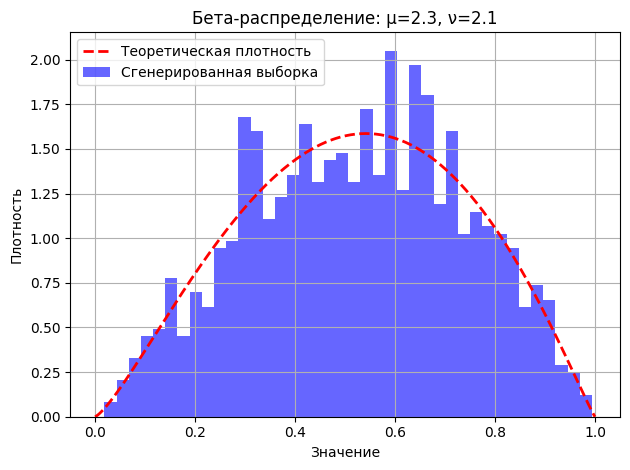

 
Статистика хи-квадрат: 1.6011
Критическое значение хи-квадрат: 14.0671
P-значение: 0.9786
Гипотеза о бета-распределении не отвергается (χ² расч. ≤ χ² крит.).
 
Теоретическое среднее: 0.523
Выборочное среднее: 0.525
Отклонение среднего: 0.002

Теоретическая дисперсия: 0.046
Выборочная дисперсия: 0.046
Отклонение дисперсии: 0.000


In [ ]:
#генерирование случайной величины с бета-распределением
#задаем параметры для бета распределения
f_beta(2.3,2.1)

Гамма-распределение

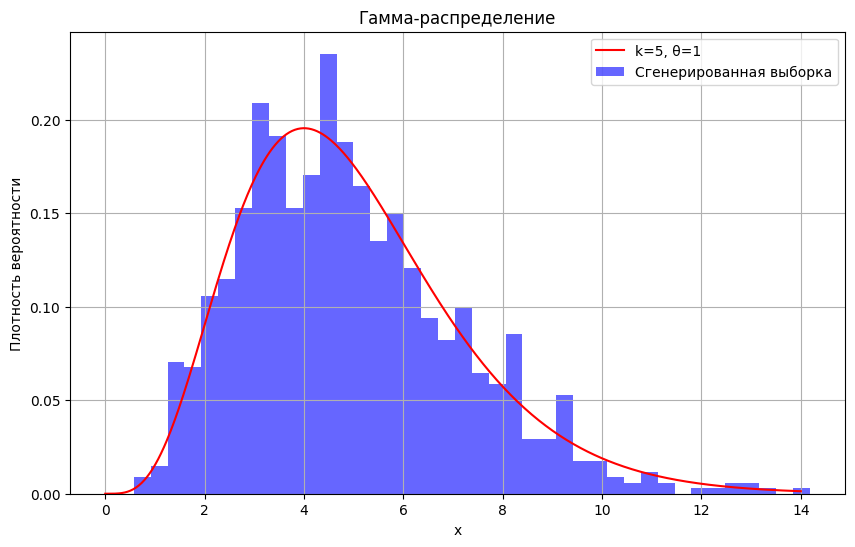

 
Статистика хи-квадрат: 7.2347
Критическое значение хи-квадрат: 14.0671
P-значение: 0.4049
Гипотеза о гамма-распределении не отвергается (χ² расч. ≤ χ² крит.).
 
Теоретическое среднее: 5.000
Выборочное среднее: 4.931
Отклонение среднего: 0.069

Теоретическая дисперсия: 5.000
Выборочная дисперсия: 4.855
Отклонение дисперсии: 0.145


In [ ]:
#генерирование случайной величины с гамма-распределением
#задаем параметры гамма-распределения
#параметр scale: θ фиксирован как 1, так как рассматриваются только случаи стандартного гамма-распределения

f_gamma(5,1)